# **RAG-Based Legal Chatbot for the Sri Lankan Constitution**


#### Install Packages, Import Libraries and set up Google drive

In [ ]:
# setup google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Uncomment to install packages and restart before running the rest

In [ ]:
# !pip install -q numpy==1.26.4
# !pip install evaluate -q
# !pip install datasets -q
# !pip install langchain -q
# !pip install langchain_community -q
# !pip install langchain-huggingface -q
# !pip install langchain_experimental -q
# !pip install langchain_chroma -q
# !pip install langchainhub -q
# !pip install -q langchain_google_genai
# !pip install gradio  -q

In [ ]:
# Core libraries
import os
import re
import json
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# Natural Language Processing libraries
import unicodedata
import regex as re
from nltk import ngrams
from nltk import FreqDist

# Datasets and evaluation
from datasets import Dataset, DatasetDict
import evaluate

# Scipy for distance metrics
from scipy.spatial.distance import cosine

# LangChain tools
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.schema import Document
from langchain_google_genai import ChatGoogleGenerativeAI

# Gradio for UI
import gradio as gr

---

##Data loading and  Data cleaning

In [ ]:
# Load the text file
loader = TextLoader("/content/drive/MyDrive/NLP/RAG/Sri Lanka Constitution-Sinhala.txt")
data = loader.load()

In [ ]:
text = data[0].page_content[:500]  # Get the first 100 characters
text

'ශ්\u200dරී ලංකා ප්\u200dරජාතාන්ත්\u200dරික සමාජවාදී ජනරජයේ ආණ්ඩුක්\u200dරම ව්\u200dයවස්ථාව\n(2022 ඔක්තෝබර් මස 31 වැනි දින දක්වා සංශෝධිතයි)\n(විසිඑක්වන සංශෝධනය දක්වා සංශෝධන අන්තර්ගත කරන ලද)\nප්\u200dරතිශෝධිත මුද්\u200dරණය 2023\nපාර්ලිමේන්තු මහ ලේකම් කාර්යාලය මගින් ප්\u200dරකාශිතයි.\n\nශ්\u200dරී ලංකා පාර්ලිමේන්තුවේ ව්\u200dයවස්ථාදායක සේවා දෙපාර්තමේන්තුවේ පනත් කෙටුම්පත් කාර්යාංශය විසින් සංස්කරණය කරන ලද මෙම නිල නොවන ප්\u200dරතිශෝධිත මුද්\u200dරණය මගින් ආණ්ඩුක්\u200dරම ව්\u200dයවස්ථාවේ විසිඑක්වන සංශෝධනය දක්වා පාර්ලිමේන්තුව විසින් වරින් වර සංශෝධනය කරන ලද ශ්\u200dරී ලංකා ප්\u200dරජාතාන'

In [ ]:
def clean_text(text):
    """Cleans text by removing unwanted Unicode characters, brackets, and unnecessary whitespace."""
    # Remove Unicode escape sequences
    text = re.sub(r'\u200d', '', text)
    # remove other unwanted symbols or patterns
    text = re.sub(r'[\[\]{}]', '', text)  # Remove brackets where needed
    # clean other unwanted characters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning to each document and store it back as Document objects
cleaned_documents = []
for doc in data:
    cleaned_text = clean_text(doc.page_content)
    cleaned_document = Document(page_content=cleaned_text, metadata=doc.metadata)  # Preserve metadata
    cleaned_documents.append(cleaned_document)

# print the cleaned content of the first document
print(cleaned_documents[0].page_content[:500])

ශ්රී ලංකා ප්රජාතාන්ත්රික සමාජවාදී ජනරජයේ ආණ්ඩුක්රම ව්යවස්ථාව (2022 ඔක්තෝබර් මස 31 වැනි දින දක්වා සංශෝධිතයි) (විසිඑක්වන සංශෝධනය දක්වා සංශෝධන අන්තර්ගත කරන ලද) ප්රතිශෝධිත මුද්රණය 2023 පාර්ලිමේන්තු මහ ලේකම් කාර්යාලය මගින් ප්රකාශිතයි. ශ්රී ලංකා පාර්ලිමේන්තුවේ ව්යවස්ථාදායක සේවා දෙපාර්තමේන්තුවේ පනත් කෙටුම්පත් කාර්යාංශය විසින් සංස්කරණය කරන ලද මෙම නිල නොවන ප්රතිශෝධිත මුද්රණය මගින් ආණ්ඩුක්රම ව්යවස්ථාවේ විසිඑක්වන සංශෝධනය දක්වා පාර්ලිමේන්තුව විසින් වරින් වර සංශෝධනය කරන ලද ශ්රී ලංකා ප්රජාතාන්ත්රික සමාජවාදී ජ


During data loading and printing a section of the dataset, it was seen that unwanted characters, symbols were present. Therefore steps were taken to remove these noise data.

##Dataset analysis and Description

In [ ]:
# Get basic text statistics
def text_analysis(data):
  text = data[0].page_content

  # Number of words
  num_words = len(text.split())

  # Number of unique words
  unique_words = set(text.split())
  num_unique_words = len(unique_words)

  print(f"Number of words: {num_words}")
  print(f"Number of unique words: {num_unique_words}")

print('Before cleaning')
text_analysis(data)
print('After cleaning')
text_analysis(cleaned_documents)

Before cleaning
Number of words: 64167
Number of unique words: 6779
After cleaning
Number of words: 64153
Number of unique words: 6696


In [ ]:
# Number of sentences
def sentence_analysis(data):
  num_sentences = text.count('.')
  # Average sentence length
  sentence_lengths = [len(sentence.split()) for sentence in text.split('.') if sentence]
  avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths)

  print(f"Number of sentences: {num_sentences}")
  print(f"Average sentence length: {avg_sentence_length:.2f} words")

print('Before cleaning')
sentence_analysis(data)
print('After cleaning')
sentence_analysis(cleaned_documents)

Before cleaning
Number of sentences: 1
Average sentence length: 32.50 words
After cleaning
Number of sentences: 1
Average sentence length: 32.50 words


In [ ]:
#Load the text file for ease to analyse
file_path = "/content/drive/MyDrive/NLP CW 2/Data /Task 4/Sri Lanka Constitution-Sinhala.txt"

# Read the content of the file
with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

sinhala_text = re.sub(r'[^අ-ෞ\s]', '', text)  # Retain only Sinhala characters and spaces

#Split the cleaned text into words
words = sinhala_text.split()

#Calculate unique word count
unique_words = set(words)
print(f"Unique words count: {len(unique_words)}")

Unique words count: 4722


In [ ]:
# Find the most common words (top 10)
word_freq = Counter(words)
most_common_words = word_freq.most_common(10)
print("Most common words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

#Find the most common bigrams (top 10)
bigrams = list(ngrams(words, 2))
bigram_freq = FreqDist(bigrams)
most_common_bigrams = bigram_freq.most_common(15)
print("")
print("Most common bigrams:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

Most common words:
හෝ: 2048
ය: 1040
විසින්: 1030
ඒ: 973
වන: 933
සහ: 900
යම්: 770
ද: 750
කරනු: 724
කිරීම: 672

Most common bigrams:
යුත්තේ ය: 494
කරන ලද: 214
කොමිෂන් සභාව: 206
කොමිෂන් සභාවේ: 200
කරනු ලබන: 174
කරනු ලැබිය: 161
සභාව විසින්: 159
තෝරා පත්: 158
ශ්රී ලකා: 155
ජනාධිපතිවරයා විසින්: 154
පාර්ලිමේන්තුව විසින්: 151
ව්යවස්ථාවේ වන: 146
කරනු ලැබූ: 145
ආණ්ඩුක්රම ව්යවස්ථාව: 144
කිරීම සඳහා: 125


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Sinhala UI.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Sinhala UI.
  fig.canvas.print_figure(bytes_io, **kw)


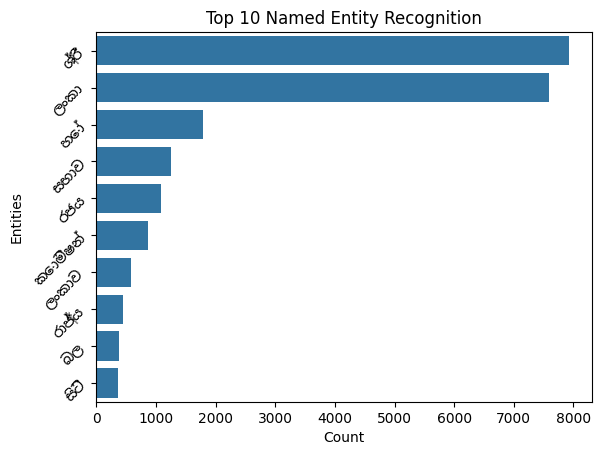

In [ ]:
# plot the most Common NER

# Load the Sinhala NER data
ner_data = pd.read_csv(r'/content/drive/MyDrive/NLP CW 2/partition_1.tsv', sep='\t',names=['entity', 'label'], header=None)

# Define font properties for Sinhala text
fontprop = font_manager.FontProperties(fname='/content/drive/MyDrive/NLP CW 2/NotoSansSinhalaUI-Medium.ttf')  # Adjust the path as needed

def _get_ner(text, ner_data):
    entities = []
    for index, row in ner_data.iterrows():
        if row['entity'] in text and row['label'] != 'O':  # Check if the entity exists in the text
            entities.append(row['entity'])
    return entities

def plot_named_entity_barchart(text_file_path):
    # Read text from the file
    with open(text_file_path, 'r', encoding='utf-8') as file:
        text = file.read()


    sentences = text.split('.')

    # Extract named entities
    ent = [ _get_ner(sentence, ner_data) for sentence in sentences ]
    ent = [x for sub in ent for x in sub]  # Flatten the list of entities

    # Count occurrences of entities
    counter = Counter(ent)

    # Get the top 10 most common entities
    x, y = map(list, zip(*counter.most_common(10)))

    # Plotting the results
    sns.barplot(x=y, y=x)
    plt.title("Top 10 Named Entity Recognition")
    plt.yticks(rotation=45, fontproperties=fontprop)  # Adjust font for Sinhala
    plt.xlabel("Count")
    plt.ylabel("Entities")
    plt.show()

plot_named_entity_barchart(file_path)

In the named entities it can be seen that Sri-lanka and its variants occur the most.

##Splitting the text

Inorder to capture context better a higher chunk size was set since law data is lengthy.

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=100)
docs = text_splitter.split_documents(cleaned_documents)
print("Total number of documents: ",len(docs))

Total number of documents:  214


In [ ]:
# print sample chunk
docs[70]

Document(metadata={'source': '/content/drive/MyDrive/NLP CW 2/Data /Task 4/Sri Lanka Constitution-Sinhala.txt'}, page_content='දිනට පසුව ඇති කරන ලද ධුරයක් වූ ද, ධුරය ඇති කරන ලද දිනයේ දී ඒ ධුරයේ වැටුප් පරිමාණයෙහි ආරම්භක වැටුප, පාර්ලිමේන්තුව විසින් යෝජනා සම්මතයක් මගින් තීරණය කරනු ලැබූ වැටුපට නැතහොත් ඉන් පසුව සිදු කරන ලද යම් වැටුප් පරිමාණ ප්රතිශෝධනයක් යටතේ එකී ආරම්භක වැටුපට අනුරූප වන වෙනත් යම් වාර්ෂික වැටුප් ප්රමාණයකට නොඅඩු වූ ද යම් ධුරයක් දරන්නා වූ, පළාත් රාජ්ය සේවයේ නිලධරයෙක්; (ix) 1970 නොවැම්බර් මස 18 වන දිනට කලින් ඇති කරන ලද ධුරයක් වූ ද, 1970 නොවැම්බර් මස 18 වන දින දී වැටුප් පරිමාණයෙහි ආරම්භක වැටුප, වර්ෂයකට රු. 7,200 ට නො අඩු වූ නැතහොත් ඉන් පසුව සිදු කරන ලද යම් වැටුප් පරිමාණ ප්රතිශෝධනයක් යටතේ එකී ආරම්භක වැටුපට අනුරූප වෙනත් යම් වාර්ෂික වැටුප් ප්රමාණයක් වූ ද ධුරයක් දරන්නා වූ රාජ්ය සංස්ථා නිලධරයෙක්; (x) 1970 නොවැම්බර් මස 18 වන දිනට පසුව ඇති කරන ලද ධුරයක් වූ ද ධුරය ඇති කරන දිනයේ දී වැටුප් පරිමාණයෙහි ආරම්භක වැටුප (ix) වන විෂයයෙහි සඳහන් ධුරයකට ඒ දිනයේ දී අදාළ වූ වැටුප් පරිමාණයෙහි ආරම්භක වැට

##Set Up Embeddings and Vector Store
GoogleGenerativeAIEmbeddings embedding model provided by Google and Croma DB are used as embedding model and vector store.

In [ ]:
os.environ["GOOGLE_API_KEY"] = 'APIKEY' # add api key here
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [ ]:
# Storing the documents in a vector store like Chroma allows for efficient retrieval based on semantic similarity.
vectorstore = Chroma.from_documents(documents=docs, embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001"))

In [ ]:
# set up retriver
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 20})

In [ ]:
# print sample from the retrieved documents
retrieved_docs = retriever.invoke("ජනවරම")
print(retrieved_docs[8].page_content)

හෝ පාර්ලිමේන්තුව විසින් නොකළ යුත්තේය. 76. (1) පාර්ලිමේන්තුව විසින් පාර්ලිමේන්තුවේ ව්‍යවස්ථාදායක බලය අත් නොහළ යුත්තේ ය. කිසිම ආකාරයකින් අන්සතු නොකළ යුත්තේ ය. කවර වූ හෝ ව්‍යවස්ථාදායක බලයක් ඇති කිසිම අධිකාරයක් පාර්ලිමේන්තුව විසින් නොපිහිටුවිය යුත්තේ ය. (2) පාර්ලිමේන්තුව විසින්, මහජන ආරක්ෂාවට අදාළ යම්කිසි නීතියකට අනුකූලව හදිසි අවස්ථා නියෝග සෑදීමේ බලය ජනාධිපතිවරයාට පැවරෙන විධිවිධාන, ඒ නීතියට ඇතුළත් කිරීම, මේ ව්‍යවස්ථාවේ (1) වන අනුව්‍යවස්ථාවේ විධිවිධාන කඩකිරීමක් නොවන්නේ ය. (Z) (අ) යම් නීතියක් හෝ යම්


##Set Up LLM as generator

Gemini-1.5-Pro is a state-of-the-art large language model (LLM) developed by Google.

It  has powerful capabilities for understanding and generating text.

The model can handle complex language tasks, which is crucial when dealing with a nuanced subject like the Sri Lankan Constitution.

Setting temperature=0.0 ensures that the model’s responses are deterministic.

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro",temperature=0.0, max_tokens=500)

In [ ]:
system_prompt = (
"""The provided document is the Constitution of Sri-Lanka 2022. This document encompasses all the legal frameworks, guidelines, and principles governing the country. It defines the structure of the state, the distribution of powers between different levels of government, and the fundamental rights and duties of citizens.

When answering questions based on this document, please follow these guidelines:
- Be precise and concise in your responses.
- Ensure that the information is accurate and directly relevant to the question.
- Highlight key articles, sections, or provisions where applicable.
- Provide context to your answers when necessary, explaining the implications or importance of specific provisions.
- Maintain a neutral and informative tone, avoiding any personal opinions or interpretations.
- If you can npt answer the question, say that you don't know.
- If the answer is not present in the context, do not answer.

The goal is to provide clear and informative answers that help the user understand the specific aspects of the Constitution of Nepal 2072."""
    "\n\n"

    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

##Set Up Retrieval-Augmented Generation (RAG) Chain

In [ ]:
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [ ]:
# sammple question and answer
response = rag_chain.invoke({"input": "ව්‍යවස්ථා විශේෂණයන් අනුව අගණකාධිපතිවරයා කෙසේ පත් කළ හැක්ද?"})
print(response["answer"])

විගණකාධිපතිවරයා පත් කරනු ලබන්නේ ආණ්ඩුක්‍රම ව්‍යවස්ථා සභාවේ නිර්දේශය මත ජනාධිපතිවරයා විසිනි.


##Testing the RAG Chain with  Sample Questions

In [ ]:
# List of Sinhala constitutional questions
questions = [
    "ජනාධිපතිවරයාට නැවත ජනවරම ලබා ගැනීමට අවශ්‍ය අවම කාලය කී වසරක්ද?",
    "ලංකා ආණ්ඩුක්‍රම ව්‍යවස්ථාවකට වරදක් කළ විට, පස් වසරක් ගත වී ඇත. ඔහුට මැතිවරණය සඳහා ඡන්දය ලබාදිය හැකිද?",
    "පාර්ලිමේන්තුව අවම වශයෙන් වසරකට කී වරක් කැඳවිය යුතුද?",
    "ලංකා ව්‍යවස්ථාව අනුව අමාත්‍ය මණ්ඩලයහි ප්‍රධානියා අගමැතිවරයාද?",
    "ජනාධිපතිවරණයක හෝ ජනමත විචාරණයක වලංගුභාවය සම්බන්ධයෙන් අවසන් තීරණය ලබාදීමට බලය ඇත්තේ කාටද?",
    "ව්‍යවස්ථා විශේෂණයන් අනුව අගණකාධිපතිවරයා කෙසේ පත් කළ හැක්ද?",
    "ලංකා ව්‍යවස්ථාව අනුව ජනාධිපතිවරයාට අමාත්‍ය මණ්ඩල සාමාජිකයන් ලෙස පත් කිරීමට නොහැකිය. මෙය සත්‍යයද?",
    "ලංකා ව්‍යවස්ථාව අනුව අගවිනිසුරු වරයා ලෙස පත්කර, ලැබූ තැනැත්තාට රාජ්‍ය තනතුරක් ලබාගත හැකිද?"
]

In [ ]:
# Store responses
results = []

for question in questions:
    try:
        response = rag_chain.invoke({"input": question})  # Call API
        answer = response["answer"]
        print(f"Q: {question}\nA: {answer}\n")
    except Exception as e:
        print(f"Error for question: {question} -> {str(e)}")

    time.sleep(30)  # Wait 3 seconds between requests


# Print results
for i, (q, ans) in enumerate(results, 1):
    print(f"Question {i}: {q}")
    print(f"Answer: {ans}\n")

Q: ජනාධිපතිවරයාට නැවත ජනවරම ලබා ගැනීමට අවශ්‍ය අවම කාලය කී වසරක්ද?
A: ජනාධිපතිවරයාට නැවත ජනවරම ලබා ගැනීමට අවශ්‍ය අවම කාලය අවුරුදු 5 කි. මෙය ආණ්ඩුක්‍රම ව්‍යවස්ථාවේ 30(3)(ඈ) වගන්තියේ සඳහන් වේ.

Q: ලංකා ආණ්ඩුක්‍රම ව්‍යවස්ථාවකට වරදක් කළ විට, පස් වසරක් ගත වී ඇත. ඔහුට මැතිවරණය සඳහා ඡන්දය ලබාදිය හැකිද?
A: මට සමාවෙන්න, ලංකා ආණ්ඩුක්‍රම ව්‍යවස්ථාව ගැන මට තොරතුරු නැහැ. ඒ නිසා මට ඒ ප්‍රශ්නයට උත්තර දෙන්න බැහැ.

Q: පාර්ලිමේන්තුව අවම වශයෙන් වසරකට කී වරක් කැඳවිය යුතුද?
A: මට ඒ ප්‍රශ්නයට පිළිතුරු දිය නොහැක. ලබා දී ඇති ආණ්ඩුක්‍රම ව්‍යවස්ථාවේ කොටසෙහි ඒ තොරතුරු නොමැත.

Q: ලංකා ව්‍යවස්ථාව අනුව අමාත්‍ය මණ්ඩලයහි ප්‍රධානියා අගමැතිවරයාද?
A: ඔව්, ශ්‍රී ලංකා ව්‍යවස්ථාවේ 43(1) වගන්තිය අනුව අමාත්‍ය මණ්ඩලයේ ප්‍රධානියා අග්‍රාමාත්‍යවරයා වේ.

Q: ජනාධිපතිවරණයක හෝ ජනමත විචාරණයක වලංගුභාවය සම්බන්ධයෙන් අවසන් තීරණය ලබාදීමට බලය ඇත්තේ කාටද?
A: ජනාධිපතිවරණයක හෝ ජනමත විචාරණයක වලංගුභාවය සම්බන්ධයෙන් අවසන් තීරණය ලබාදීමට බලය ඇත්තේ ශ්‍රේෂ්ඨාධිකරණයටයි. ජනාධිපතිවරයා විසින් අදාළ පනත් කෙටුම්පතකට සහතිකයක් ලබාදීමෙන් පසු, එම සහතිකය අවසානාත්

##Test without RAG

In [ ]:
# RAG Chatbot
def rag_chatbot(query):
    # Retrieve relevant documents
    retrieved_docs = retriever.invoke(query)
    context = " ".join([doc.page_content for doc in retrieved_docs])

    # Generate answer using the RAG chain
    response = rag_chain.invoke({"input": query})
    return response["answer"]

In [ ]:
# Non-RAG Chatbot
def non_rag_chatbot(query):
    # Generate answer directly using the language model
    response = llm.invoke(query)
    return response.content

In [ ]:
# Store responses
results = []

# Answer all questions using the Non-RAG chatbot
for question in questions:
    answer = non_rag_chatbot(question)
    results.append((question, answer))

    print(f"Question: {question}")
    print(f"Non-RAG Answer: {answer}\n")

    time.sleep(60)  # Delay to avoid API rate limits

Question: ජනාධිපතිවරයාට නැවත ජනවරම ලබා ගැනීමට අවශ්‍ය අවම කාලය කී වසරක්ද?
Non-RAG Answer: ශ්‍රී ලංකාවේ ජනාධිපතිවරයෙකුට නැවත ජනවරම ලබා ගැනීමට අවශ්‍ය අවම කාලය වසර **පහ**කි. ජනාධිපතිවරයෙකුගේ ධුර කාලය වසර පහක් වන අතර, එම කාලය අවසානයේ නැවත මැතිවරණයක් පවත්වනු ලැබේ. ජනාධිපතිවරයාට එම මැතිවරණයෙන් ජයග්‍රහණය කළහොත්, ඔහුට තවත් වසර පහක කාලයක් සඳහා ජනාධිපති ධුරය දැරීමට අවස්ථාව ලැබේ.

Question: ලංකා ආණ්ඩුක්‍රම ව්‍යවස්ථාවකට වරදක් කළ විට, පස් වසරක් ගත වී ඇත. ඔහුට මැතිවරණය සඳහා ඡන්දය ලබාදිය හැකිද?
Non-RAG Answer: ශ්‍රී ලංකා ආණ්ඩුක්‍රම ව්‍යවස්ථාවට අනුව, පුද්ගලයෙකුට ඡන්ද අයිතිය අහිමි වන අවස්ථා කිහිපයක් තිබේ. එක් අවස්ථාවක් වන්නේ ආණ්ඩුක්‍රම ව්‍යවස්ථාවට වරදක් කිරීමයි. එවැනි වරදක් සම්බන්ධයෙන් චෝදනා ලැබූ පුද්ගලයෙකුට ඡන්ද අයිතිය අහිමි විය හැකිය. 

කෙසේ වෙතත්, එම පුද්ගලයාට වසර පහකට පසු ඡන්ද අයිතිය නැවත ලබා ගත හැකිය. ඒ සඳහා ඔහු හෝ ඇය ජනාධිපතිට ලිඛිතව ඉල්ලීමක් කළ යුතුය. ජනාධිපතිවරයාට එම ඉල්ලීම පිළිගෙන ඡන්ද අයිතිය නැවත ලබා දිය හැකිය.

එබැවින්, ආණ්ඩුක්‍රම ව්‍යවස්ථාවට වරදක් කළ පුද්ගලයෙකුට වසර පහකට පසු ඡන්දය ප්‍රකාශ කි

##Further Results intepretations

This function calculates the Mean Reciprocal Rank score, a metric used to evaluate the effectiveness of a retrieval system.

MRR measures how quickly a relevant document (answer) is retrieved for each question.

In [ ]:
def mean_reciprocal_rank(retriever, questions, ground_truths):
    rr_sum = 0
    for question, answer in zip(questions, ground_truths):
        retrieved_docs = retriever.invoke(question)
        retrieved_texts = [doc.page_content for doc in retrieved_docs]

        # Find rank of first relevant document
        rank = next((i + 1 for i, doc in enumerate(retrieved_texts) if answer in doc), 0)
        if rank > 0:
            rr_sum += 1 / rank

    return rr_sum / len(questions)  # MRR score

# List of questions
questions = [
    "ජනාධිපතිවරයාට නැවත ජනවරම ලබා ගැනීමට අවශ්‍ය අවම කාලය කී වසරක්ද?",
    "ලංකා ව්‍යවස්ථාව අනුව අමාත්‍ය මණ්ඩලයහි ප්‍රධානියා අගමැතිවරයාද?",
    "ලංකා ව්‍යවස්ථාව අනුව අගවිනිසුරු වරයා ලෙස පත්කර, ලැබූ තැනැත්තාට රාජ්‍ය තනතුරක් ලබාගත හැකිද?",
    "ලංකා ව්‍යවස්ථාව අනුව ජනාධිපතිවරයාට අමාත්‍ය මණ්ඩල සාමාජිකයන් ලෙස පත් කිරීමට නොහැකිය. මෙය සත්‍යයද?"
]

# Corresponding ground truths for each question
ground_truths = [
    "අවුරුදු 5 කි",  # Answer for the first question
    "ඔව්",
    "නැත",  # Answer for the second question
    "නැත",  # Answer for the third question
]

# Compute MRR
mrr_score = mean_reciprocal_rank(retriever, questions, ground_truths)
print(f"Mean Reciprocal Rank (MRR): {mrr_score:.2f}")

Mean Reciprocal Rank (MRR): 0.29


A lower MRR score (0.29) suggests that the relevant answers are found deeper in the retrieval results, indicating the system might not be retrieving the most relevant documents early enough.

##RAG Chatbot Setup with UI

 Gradio chatbot was implemented which can respond to questions about the Sri Lankan Constitution in Sinhala. Users can choose between two methods: "RAG" (Retrieval-Augmented Generation) or "Non-RAG". The chatbot will return answers based on the selected method. The interface consists of a textbox for the question and a radio button to select the method

In [ ]:
def chatbot_interface(query, method):
    if method == "RAG":
        return rag_chatbot(query)
    elif method == "Non-RAG":
        return non_rag_chatbot(query)

# Create the Gradio interface
interface = gr.Interface(
    fn=chatbot_interface,
    inputs=[
        gr.Textbox(label="Ask a question"),
        gr.Radio(["RAG", "Non-RAG"], label="Choose Chatbot Method")
    ],
    outputs="text",
    title="Sri Lanka Constitution Q&A",
    description="Select between RAG-based and Non-RAG chatbot to get answers about the Constitution of Sri Lanka in Sinhala"
)

# Launch the interface
interface.launch()

### Intepretation of results

 **Questions and Answers Status WITH RAG**:

1. ජනාධිපතිවරයාට නැවත ජනවරම ලබා ගැනීමට අවශ්‍ය අවම කාලය කී වසරක්ද?
   - Answer --> Got an answer.

2. ලංකා ආණ්ඩුක්‍රම ව්‍යවස්ථාවකට වරදක් කළ විට, පස් වසරක් ගත වී ඇත. ඔහුට මැතිවරණය සඳහා ඡන්දය ලබාදිය හැකිද?
   - Answer --> Not answered.

3. පාර්ලිමේන්තුව අවම වශයෙන් වසරකට කී වරක් කැඳවිය යුතුද?
   - Answer --> Got an answer.

4. ලංකා ව්‍යවස්ථාව අනුව අමාත්‍ය මණ්ඩලයහි ප්‍රධානියා අගමැතිවරයාද?  
   - Answer --> Got an answer.

5. ජනාධිපතිවරණයක හෝ ජනමත විචාරණයක වලංගුභාවය සම්බන්ධයෙන් අවසන් තීරණය ලබාදීමට බලය ඇත්තේ කාටද?
   - Answer --> Got an answer.

6. **ව්‍යවස්ථා විශේෂණයන් අනුව අගණකාධිපතිවරයා කෙසේ පත් කළ හැක්ද?**  
   - Answer --> Got an answer.

7. ලංකා ව්‍යවස්ථාව අනුව ජනාධිපතිවරයාට අමාත්‍ය මණ්ඩල සාමාජිකයන් ලෙස පත් කිරීමට නොහැකිය. මෙය සත්‍යයද?
   - Answer --> Not answered.

8. ලංකා ව්‍යවස්ථාව අනුව අගවිනිසුරු වරයා ලෙස පත්කර, ලැබූ තැනැත්තාට රාජ්‍ය තනතුරක් ලබාගත හැකිද?*
   - Answer --> Got an answer (but it was incorrect).

---
#### 6/8 questions were answered while 5/8 questions were answered correctly   
---

**Comparison between answer geenrated  with and Without RAG**

Q: ජනාධිපතිවරයාට නැවත ජනවරම ලබා ගැනීමට අවශ්‍ය අවම කාලය කී වසරක්ද?

Answer with RAG: ජනාධිපතිවරයාට නැවත ජනවරම ලබා ගැනීමට අවශ්‍ය අවම කාලය අවුරුදු 5 කි. මෙය ආණ්ඩුක්‍රම ව්‍යවස්ථාවේ 30(3)(ඈ) වගන්තියේ සඳහන් වේ.

Non-RAG Answer: ශ්‍රී ලංකාවේ ජනාධිපතිවරයෙකුට නැවත ජනවරම ලබා ගැනීමට අවශ්‍ය අවම කාලය වසර පහකි. ජනාධිපතිවරයෙකුගේ ධුර කාලය වසර පහක් වන අතර, එම කාලය අවසානයේ නැවත මැතිවරණයක් පවත්වනු ලැබේ. ජනාධිපතිවරයාට එම මැතිවරණයෙන් ජයග්‍රහණය කළහොත්, ඔහුට තවත් වසර පහක කාලයක් සඳහා ජනාධිපති ධුරය දැරීමට අවස්ථාව ලැබේ.


---

> #### While without RAG all questions were answered but the information was not entirely correct. There were mismatches in the answers.

> #### With the RAG the answers had better context and citations and better narative style and consise answers.

> #### All the  False Premise Questions seems have failed with RAG.
